In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from utils import get_median_price, classify_price
import matplotlib.pyplot as plt
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

random_seed = 42

import os
mlflow_tracking_uri = os.path.join(os.path.dirname(os.getcwd()), 'mlruns')
print(f"MLflow tracking URI: {mlflow_tracking_uri}")

# Change to \\ if on Windows
if os.name == 'nt':
    mlflow.set_tracking_uri(f"file:\\{mlflow_tracking_uri}")
else:
    mlflow.set_tracking_uri(f"file://{mlflow_tracking_uri}")

mlflow.end_run()
mlflow.set_experiment("classification_models")

MLflow tracking URI: C:\Users\caleb\PycharmProjects\MLProject\CS4120-MLProject\project\mlruns


<Experiment: artifact_location='file:\\C:\\Users\\caleb\\PycharmProjects\\MLProject\\CS4120-MLProject\\project\\mlruns/637613118783091569', creation_time=1761758332462, experiment_id='637613118783091569', last_update_time=1761758332462, lifecycle_stage='active', name='classification_models', tags={}>

In [35]:
df = pd.read_csv('../data/train.csv')

# Step 2: Process Data
median_price = get_median_price(df)
df['PriceCategory'] = df['SalePrice'].apply(lambda x: classify_price(x, median_price))

# Remove Id and SalePrice columns
df = df.drop(['Id', 'SalePrice'], axis=1)
# Combine bathroom features
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df = df.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1)

# Combine porch features into one
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df = df.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)

# Drop low-variance features
df = df.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'], axis=1)

# Drop Year/Month sold (temporal features may cause overfitting)
df = df.drop(['MoSold', 'YrSold'], axis=1)

# Combine quality features
df['OverallScore'] = df['OverallQual'] * df['OverallCond']
# Redundant features
df = df.drop(['GarageType', 'GarageFinish', 'Fence', 'Alley'], axis=1)
df = df.drop(['LowQualFinSF', 'PoolArea', 'MiscVal'], axis=1)
df = df.drop(['GarageQual', 'GarageCond'], axis=1)
df = df.drop(['PoolQC', 'MiscFeature'], axis=1)

# Separate features and target
X = df.drop('PriceCategory', axis=1)
y = df['PriceCategory']

In [36]:
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (1460, 56)
Target shape: (1460,)


In [37]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Split the data: 80% training, 20% testing
X_main, X_test, y_main, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed
)

X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size=0.125, random_state=random_seed
)

In [38]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Numerical pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine both pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Size after preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
print(f"Preprocessed training data shape: {X_train_preprocessed.shape}")

# Fit preprocessor once on training data to avoid data leakage
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

Preprocessed training data shape: (1022, 217)


In [39]:
from sklearn.model_selection import cross_val_score

mlflow.set_experiment("Classification_NN")
mlflow.start_run(run_name="classification_nn_gridsearch")

# Grid Search to find the best set of hidden layer sizes
base_mlp = MLPClassifier(max_iter=500, random_state=random_seed, early_stopping=False)

# Hyperparameter grid to search
param_grid = {
    "hidden_layer_sizes": [(75,), (75, 37), (75, 37, 18, 9,), (150, 75, 37, 18,),
                           ],
    "activation": ["relu", "logistic"],
    "alpha": [0.01, 0.05, 0.1],
    "solver": ["adam"]
}

# Grid search with 4-fold CV
grid_search = GridSearchCV(
    estimator=base_mlp,
    param_grid=param_grid,
    cv=4,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
    refit=True
)

# Fit grid search on the training data
print("Starting GridSearchCV fit...")
grid_search.fit(X_train_preprocessed, y_train)
print("GridSearchCV complete.")

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

# Initial params
mlflow.log_param("random_seed", random_seed)
mlflow.log_param("test_size", 0.2)
mlflow.log_param("activation", grid_search.best_params_['activation'])
mlflow.log_param("solver", "adam")
mlflow.log_param("max_iter", 500)

# Log best parameters
mlflow.log_param("best_hidden_layer_sizes", str(grid_search.best_params_['hidden_layer_sizes']))
mlflow.log_metric("best_cv_score", -grid_search.best_score_)

best_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_model, X_train_preprocessed, y_train, cv=4, scoring='accuracy')


Starting GridSearchCV fit...
Fitting 4 folds for each of 24 candidates, totalling 96 fits
GridSearchCV complete.

Best parameters found:
{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (75, 37, 18, 9), 'solver': 'adam'}
Best CV accuracy: 0.9256


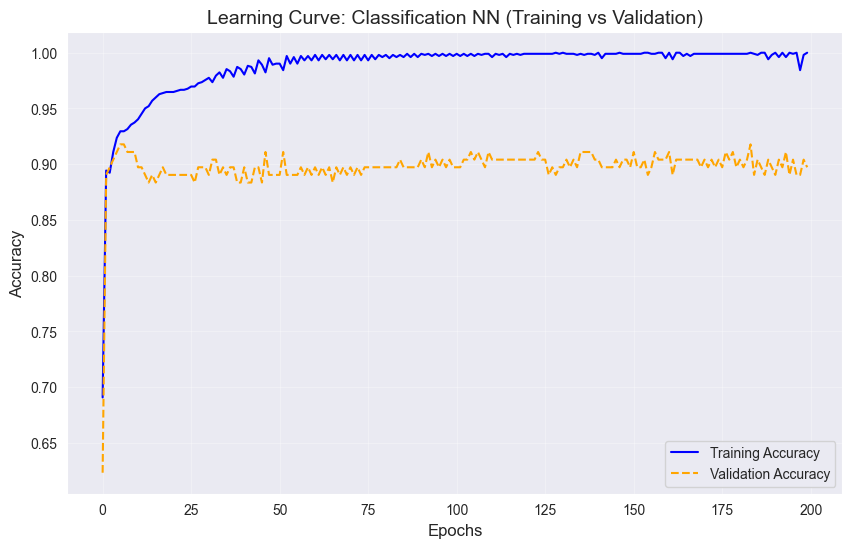

In [40]:
best_params = grid_search.best_params_

mlp_model_to_use = MLPClassifier(
    **best_params,
    max_iter=1,
    random_state=random_seed,
    warm_start=True,
    early_stopping=False,
    verbose=False,
)

train_accuracy_history = []
val_accuracy_history = []

n_epochs = 200
mlflow.log_param("n_epochs", n_epochs)

for epoch in range(n_epochs):
    mlp_model_to_use.fit(X_train_preprocessed, y_train)

    # Training Accuracy
    y_train_pred_mon = mlp_model_to_use.predict(X_train_preprocessed)
    train_accuracy_mon = accuracy_score(y_train, y_train_pred_mon)
    train_accuracy_history.append(train_accuracy_mon)

    # Validation Accuracy (using X_val as validation here)
    y_val_pred_mon = mlp_model_to_use.predict(X_val_preprocessed)
    val_accuracy_mon = accuracy_score(y_val, y_val_pred_mon)
    val_accuracy_history.append(val_accuracy_mon)

plt.figure(figsize=(10, 6))
plt.plot(train_accuracy_history, label='Training Accuracy', color='blue')
plt.plot(val_accuracy_history, label='Validation Accuracy', color='orange', linestyle='--')

plt.title('Learning Curve: Classification NN (Training vs Validation)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

mlflow.log_figure(plt.gcf(), 'plot1.png')

plt.show()

In [41]:
# Train the final model with optimal number of epochs
optimal_epochs = 125

final_model = MLPClassifier(
    **best_params,
    max_iter=optimal_epochs,
    random_state=random_seed,
    early_stopping=False,
    verbose=False,
)

final_model.fit(X_train_preprocessed, y_train)

mlflow.log_param("final_epochs", optimal_epochs)

125

In [42]:
# Use the trained model for predictions
y_train_pred = final_model.predict(X_train_preprocessed)
y_test_pred = final_model.predict(X_test_preprocessed)

# Calculate metrics for training set
train_accuracy = accuracy_score(y_train, y_train_pred)

train_f1 = f1_score(y_train, y_train_pred, average='micro')

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='micro')

# Log metrics to MLFlow
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_f1", train_f1)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_f1", test_f1)

# Log the model
mlflow.sklearn.log_model(final_model, "model")


print("\nTest set performance:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("Classification report:")
print(classification_report(y_test, y_test_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("-"*40)
print("Training Set Performance:")
print(f"CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 (Binary): {train_f1:.4f}")
print("-"*40)
print("Test Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 (Binary): {test_f1:.4f}")
print("-"*40)
mlflow.end_run()

2025/11/23 14:12:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 14:12:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Test set performance:
Accuracy: 0.9349
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       161
           1       0.90      0.96      0.93       131

    accuracy                           0.93       292
   macro avg       0.93      0.94      0.93       292
weighted avg       0.94      0.93      0.94       292

Confusion matrix:
[[147  14]
 [  5 126]]
----------------------------------------
Training Set Performance:
CV Score: 0.9256 ± 0.0174
Accuracy: 1.0000
F1 (Binary): 1.0000
----------------------------------------
Test Set Performance:
Accuracy: 0.9349
F1 (Binary): 0.9349
----------------------------------------
